# DA3 assignment 2 
## predicting fast growing firms 
by ghadena and peter

## Importing packages and defining helper functions 

In [1]:
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import patsy
import sklearn.metrics as metrics
import statsmodels.formula.api as smf
from plotnine import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
)

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import (
    auc,
    brier_score_loss,
    confusion_matrix,
    mean_squared_error,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tools.eval_measures import rmse

warnings.filterwarnings("ignore")

In [2]:
# ----------------------------
# 📌 Defining helper functions 
# ----------------------------

color = ['blue', 'red', 'green','purple']

def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance = metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error = metrics.mean_absolute_error(y_true, y_pred)
    mse = metrics.mean_squared_error(y_true, y_pred)
    median_absolute_error = metrics.median_absolute_error(y_true, y_pred)
    r2 = metrics.r2_score(y_true, y_pred)

    print("explained_variance: ", round(explained_variance, 4))
    print("r2: ", round(r2, 4))
    print("MAE: ", round(mean_absolute_error, 4))
    print("MSE: ", round(mse, 4))
    print("RMSE: ", round(np.sqrt(mse), 4))


def coef_matrix(X, model):

    coef_matrix = pd.concat(
        [pd.DataFrame(X.columns), pd.DataFrame(np.transpose(model.coef_))], axis=1
    )
    coef_matrix.columns = ["variable", "coefficient"]
    coef_matrix = coef_matrix.append(
        {"variable": "Intercept", "coefficient": model.intercept_},
        ignore_index=True,
    )
    return coef_matrix


def cv_summary(lambdas, C_values, model):
    d = {
        "lambdas": lambdas,
        "C_values": C_values,
        "mean_cv_score": model.scores_[1].mean(axis=0),
    }
    return pd.DataFrame(data=d)


def create_roc_plot(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    all_coords = pd.DataFrame({"fpr": fpr, "tpr": tpr, "thresholds": thresholds})

    plot = (
        ggplot(all_coords, aes(x="fpr", y="tpr"))
        + geom_line(color=color[0], size=0.7)
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1), expand=(0, 0.01))
        + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1, 0.1), expand=(0.01, 0))
        + theme_bw()
    )
    return plot


def sigmoid_array(x):
    return 1 / (1 + np.exp(-x))


def generate_fold_prediction(model, X, fold, param_index):
    fold_coef = model.coefs_paths_[1][fold, param_index, :]
    return sigmoid_array(
        np.dot(X, np.transpose(fold_coef)[:-1]) + np.transpose(fold_coef)[-1]
    )


def create_loss_plot(all_coords, optimal_threshold, curr_exp_loss):
    all_coords_copy = all_coords.copy()
    all_coords_copy["loss"] = (
        all_coords_copy.false_pos * FP + all_coords_copy.false_neg * FN
    ) / all_coords_copy.n

    t = optimal_threshold
    l = curr_exp_loss

    plot = (
        ggplot(all_coords_copy, aes(x="thresholds", y="loss"))
        + geom_line(color=color[0], size=0.7)
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + coord_cartesian(xlim=(0, 1))
        + geom_vline(xintercept=t, color=color[0])
        + annotate(
            geom="text",
            x=t - 0.01,
            y=max(all_coords_copy.loss) - 0.4,
            label="best threshold: " + str(round(t, 2)),
            colour=color[1],
            angle=90,
            size=7,
        )
        + annotate(geom="text", x=t + 0.06, y=l, label=str(round(l, 2)), size=7)
        + theme_bw()
    )
    return plot


def create_roc_plot_with_optimal(all_coords, optimal_threshold):
    all_coords_copy = all_coords.copy()
    all_coords_copy["sp"] = 1 - all_coords_copy.true_neg / all_coords_copy.neg
    all_coords_copy["se"] = all_coords_copy.true_pos / all_coords_copy.pos

    best_coords = all_coords_copy[all_coords_copy.thresholds == optimal_threshold]
    sp = best_coords.sp.values[0]
    se = best_coords.se.values[0]

    plot = (
        ggplot(all_coords_copy, aes(x="sp", y="se"))
        + geom_line(color=color[0], size=0.7)
        + scale_y_continuous(breaks=np.arange(0, 1.1, 0.1))
        + scale_x_continuous(breaks=np.arange(0, 1.1, 0.1))
        + geom_point(data=pd.DataFrame({"sp": [sp], "se": [se]}))
        + annotate(
            geom="text",
            x=sp,
            y=se + 0.03,
            label=str(round(sp, 2)) + ", " + str(round(se, 2)),
            size=7,
        )
        + geom_area(position="identity", fill="mediumaquamarine", alpha=0.3)
        + xlab("False Positive Rate (1-Specifity)")
        + ylab("True Positive Rate (Sensitivity)")
        + geom_abline(intercept=0, slope=1, linetype="dotted", color="black")
        + theme_bw()
    )
    return plot

def create_calibration_plot(
    data_holdout,
    file_name="calibration_plot",
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
):
    """
    Generates a calibration plot to compare predicted probabilities vs. actual event probabilities.
    
    Parameters:
    - data_holdout (pd.DataFrame): The dataset containing predicted probabilities and actual outcomes.
    - file_name (str): The name for saving the figure (default: "calibration_plot").
    - prob_var (str): Column name for predicted probabilities.
    - actual_var (str): Column name for actual binary outcomes (0 or 1).
    - y_lab (str): Label for the y-axis (default: "Actual event probability").
    - n_bins (int): Number of bins for grouping predictions into probability intervals (default: 10).
    - breaks (list or None): Custom bin edges if specified (default: None).

    Returns:
    - Displays and saves the calibration plot as an image.
    """
    
    # Ensure valid probability values (between 0 and 1)
    data_holdout = data_holdout[(data_holdout[prob_var] >= 0) & (data_holdout[prob_var] <= 1)]
    
    # Compute the calibration curve (fraction of positives per bin)
    actual, predicted = calibration_curve(
        data_holdout[actual_var], data_holdout[prob_var], n_bins=n_bins, strategy="quantile"
    )
    
    # Create the plot
    plt.figure(figsize=(8, 6))
    plt.plot(predicted, actual, marker="o", linestyle="-", label="Calibration curve")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Perfectly calibrated")  # 45-degree line
    
    # Labels and title
    plt.xlabel("Predicted probability")
    plt.ylabel(y_lab)
    plt.title("Calibration Curve: Estimated vs. Actual Probabilities")
    plt.legend()
    
    # Save and show plot
    plt.savefig(f"{file_name}.png", dpi=300, bbox_inches="tight")
    plt.show()


## 📌 Import Data

### Importing and Cleaning Data
We imported the **cleaned dataset** from the preprocessing step, ensuring it was **free of missing values** and well-structured for analysis. Below are the key **data cleaning, label engineering, and transformation steps** performed.

---

### 🔹 Data Cleaning Steps
- **Handled missing values:**
  - **Dropped variables** with excessive missing values.
  - **Added missing year-firm (`year`, `comp_id`) combinations**, ensuring each firm has an entry for every year.
- **Performed label engineering**:
  - **Created the target variable (`fast_growth`)** based on firm sales growth.
- **Removed potential data leakage**:
  - **Dropped log-transformed sales lag variables and the winsorized sales growth version** to ensure no future data influenced the model.
  - **Filtered the dataset to include only 2012** to prevent unintended information leakage from future observations.

---

### 🔹 Creating the Target Variable: Fast Growth
The **target variable (`fast_growth`)** was constructed based on the **year-over-year sales growth** of firms. We define a firm as **"fast-growing"** if its **log sales growth exceeds 20%**. 

#### **📌 Why 20%?**
- This **threshold aligns with the OECD definition of high-growth firms**, making our model **comparable to economic research**.
- It captures **firms growing at an economically significant rate** while excluding minor fluctuations.
- We measure **growth over one year (2012 to 2013)** rather than two years to:
  - **Capture more recent expansion trends.**
  - **Retain a larger sample size**, avoiding firm exits or major structural changes.

---

### 🔹 Sample Design
- **The dataset is limited to 2012** to ensure the model is trained exclusively on past information.
- **Implemented revenue constraints**:
  - **Included firms with revenue below €10 million but above €1,000** to maintain consistency across firm sizes.
  - **Excluded extreme outliers**.
- **Final dataset contains** **19,036 observations** and **112 features**.
- **31.6% of firms in the sample are classified as fast-growing**.

---

### 🔹 Feature Engineering
- **Updated industry classification codes** to align with standardized definitions.
- **Created firm characteristics**:
  - `age_squared` (to capture non-linear age effects).
  - `foreign_management`, `gender`, and `region` indicators.
- **Financial variable transformations**:
  - **Created financial ratios** for **profitability and operational efficiency**.
  - **Generated total assets** and **normalized balance sheet & P&L elements** by sales.
  - **Added a flag for missing or zero asset values**.
  - **Winsorized** extreme values to limit the impact of outliers.
- **Performed imputation**:
  - **CEO age** (to handle missing values).
  - **Number of employees**, as it was a noisy measure.

---

### 📊 Key Insights
- **31.6% of firms in our sample are classified as "fast growers".**
- **The dataset is now fully structured for predictive modeling**, with only 2012 data retained to avoid data leakage.
---

### 🚀 What’s Next?
This cleaned dataset is now **ready for modeling**, with features structured to **minimize leakage** and **optimize predictive accuracy**. 🚀

In [3]:
# read data directly from github: 
data = pd.read_csv("https://media.githubusercontent.com/media/ghadena/DA3/refs/heads/main/assignment_2/firms_clean.csv")


In [4]:
data.describe()

,year,comp_id,amort,curr_assets,curr_liab,extra_exp,extra_inc,extra_profit_loss,fixed_assets,inc_bef_tax,...,share_eq_bs_quad,ceo_age,flag_low_ceo_age,flag_high_ceo_age,flag_miss_ceo_age,ceo_young,labor_avg_mod,flag_miss_labor_avg,sales_mil_log_sq,profit_margin
count,19036.0,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,19036.000000,1.903600e+04,1.903600e+04,1.903600e+04,1.903600e+04,...,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,19036.000000,1.903600e+04,19036.000000
mean,2012.0,1.529275e+11,9.274374e+03,9.914862e+04,8.567028e+04,418.017165,1.641894e+03,1.220200e+03,1.451590e+05,5.869079e+03,...,0.489963,46.429850,0.011189,0.004150,0.145619,0.267388,0.627548,0.135900,1.225573e+01,-0.202448
std,0.0,1.377319e+11,4.975021e+04,4.377075e+05,4.202974e+05,7141.930068,3.283540e+04,3.212567e+04,1.105861e+06,1.305634e+05,...,0.393777,10.337327,0.105189,0.064289,0.352733,0.442608,1.473032,0.342692,1.042676e+01,5.821007
min,2012.0,1.001541e+06,-1.489630e+04,0.000000e+00,-8.759259e+03,-1418.518555,-1.740741e+02,-2.484481e+05,0.000000e+00,-1.091879e+07,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.000000,2.074996e-07,-136.853061
25%,2012.0,2.868348e+10,1.185185e+02,3.314815e+03,3.822222e+03,0.000000,0.000000e+00,0.000000e+00,1.074074e+02,-6.519444e+03,...,0.088205,39.000000,0.000000,0.000000,0.000000,0.000000,0.125000,0.000000,4.049695e+00,-0.241560
50%,2012.0,1.142688e+11,8.814815e+02,1.146852e+04,1.485185e+04,0.000000,0.000000e+00,0.000000e+00,4.600000e+03,2.407407e+02,...,0.429906,46.467364,0.000000,0.000000,0.000000,0.000000,0.291667,0.000000,9.767982e+00,0.000596
75%,2012.0,2.556061e+11,4.070370e+03,4.023333e+04,4.803796e+04,0.000000,0.000000e+00,0.000000e+00,3.940926e+04,4.066667e+03,...,0.990197,53.000000,0.000000,0.000000,0.000000,1.000000,0.621691,0.000000,1.754330e+01,0.037886
max,2012.0,4.641050e+11,3.570863e+06,1.874527e+07,3.660118e+07,666300.000000,3.266667e+06,3.253704e+06,1.036673e+08,4.378226e+06,...,1.000000,75.000000,1.000000,1.000000,1.000000,1.000000,42.118057,1.000000,4.771708e+01,752.109993


In [5]:
data.fast_growth.value_counts(normalize=True)

fast_growth
0    0.683915
1    0.316085
Name: proportion, dtype: float64

### Correlation and Multicollinearity Check

There are many highly correlated variables in the dataset, but upon closer examination, most of these features are either **directly derived from each other** through feature engineering (e.g., binary variables, squared terms, and log transformations) or **conceptually related** (e.g., different representations of the same financial metric). Many correlations arise from **mathematical relationships**, such as `age` and `age²` or `sales` and `log(sales)`, while others come from **categorical encodings and flags** that capture similar information. Despite the high correlations, the Variance Inflation Factor (VIF) analysis did not identify multicollinearity issues, likely because the relationships do not create redundancy in the model.

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# ----------------------------
# 📌 Identify Categorical Variables 🏷️
# ----------------------------
categorical_vars = data.select_dtypes(include=['object', 'category']).columns.to_list()

# 🛠️ Manually add 'begin' and 'end' (since they are causing issues)
categorical_vars.extend(['begin', 'end'])

# ----------------------------
# 📌 Drop Categorical Variables 🗑️
# ----------------------------
df_filtered = data.drop(columns=categorical_vars)

# ----------------------------
# 📌 Compute Correlation Matrix 📊
# ----------------------------
corr_matrix = df_filtered.corr()

# ----------------------------
# 📌 Identify Highly Correlated Features 🔍
# ----------------------------
high_corr_pairs = [
    (corr_matrix.index[x], corr_matrix.columns[y]) 
    for x, y in zip(*np.where(np.abs(corr_matrix) > 0.8)) 
    if x < y  # Avoid duplicates
]

# ✅ Print results
print("Highly correlated feature pairs (|correlation| > 0.8):")
print(high_corr_pairs)

# ----------------------------
# 📌 Calculate Variance Inflation Factor (VIF) 📈
# ----------------------------
X = df_filtered.drop(columns=[target]).dropna()  # 🛠️ Drop NaNs

# 🚨 Drop constant columns (zero variance)
X = X.loc[:, X.nunique() > 1]

# ✅ Compute VIF for each feature
vif_data = pd.DataFrame({
    'Feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})

# ----------------------------
# 📌 Print VIF Results 📢
# ----------------------------
print("\nVariance Inflation Factor (VIF):")
print(vif_data.sort_values(by="VIF", ascending=False))  # 🏆 Sort for better readability

Highly correlated feature pairs (|correlation| > 0.8):
[('amort', 'total_assets_bs'), ('extra_inc', 'extra_profit_loss'), ('fixed_assets', 'tang_assets'), ('fixed_assets', 'total_assets_bs'), ('inc_bef_tax', 'profit_loss_year'), ('material_exp', 'sales'), ('material_exp', 'sales_mil'), ('personnel_exp', 'sales'), ('personnel_exp', 'sales_mil'), ('personnel_exp', 'labor_avg_mod'), ('sales', 'sales_mil'), ('tang_assets', 'total_assets_bs'), ('balsheet_length', 'balsheet_notfullyear'), ('founded_year', 'age'), ('founded_year', 'age2'), ('foreign', 'foreign_management'), ('birth_year', 'ceo_age'), ('nace_main', 'ind2'), ('nace_main', 'ind'), ('nace_main', 'ind2_cat'), ('ind2', 'ind'), ('ind2', 'ind2_cat'), ('ind', 'ind2_cat'), ('ln_sales', 'sales_mil_log'), ('ln_sales', 'sales_mil_log_sq'), ('sales_mil_log', 'sales_mil_log_sq'), ('age', 'age2'), ('extra_inc_pl', 'extra_profit_loss_pl'), ('extra_inc_pl', 'extra_profit_loss_pl_quad'), ('inc_bef_tax_pl', 'profit_loss_year_pl'), ('fixed_assets

## Model building

### Define variable sets 

 Main firm variables

In [12]:
rawvars = [
    "curr_assets",
    "curr_liab",
    "extra_exp",
    "extra_inc",
    "extra_profit_loss",
    "fixed_assets",
    "inc_bef_tax",
    "intang_assets",
    "inventories",
    "liq_assets",
    "material_exp",
    "personnel_exp",
    "profit_loss_year",
    #"sales",
    "share_eq",
    "subscribed_cap",
]

Further financial variables

In [13]:
qualityvars = ["balsheet_flag", "balsheet_length", "balsheet_notfullyear"]
engvar = [
    "total_assets_bs",
    "fixed_assets_bs",
    "liq_assets_bs",
    "curr_assets_bs",
    "share_eq_bs",
    "subscribed_cap_bs",
    "intang_assets_bs",
    "extra_exp_pl",
    "extra_inc_pl",
    "extra_profit_loss_pl",
    "inc_bef_tax_pl",
    "inventories_pl",
    "material_exp_pl",
    "profit_loss_year_pl",
    "personnel_exp_pl",
]
engvar2 = [
    "extra_profit_loss_pl_quad",
    "inc_bef_tax_pl_quad",
    "profit_loss_year_pl_quad",
    "share_eq_bs_quad",
]

 Flag variables

In [14]:
engvar3 = []
for col in data.columns:
    if (
        col.endswith("flag_low")
        or col.endswith("flag_high")
        or col.endswith("flag_error")
        or col.endswith("flag_zero")
    ):
        engvar3.append(col)

Growth variables - removed due to data leakage, added defaults metric instead 

In [16]:
# d1 = [
#     "d1_sales_mil_log_mod",
#     "d1_sales_mil_log_mod_sq",
#     "flag_low_d1_sales_mil_log",
#     "flag_high_d1_sales_mil_log",
# ]


Human capital related variables

In [17]:
hr = [
    "female",
    "ceo_age",
    "flag_high_ceo_age",
    "flag_low_ceo_age",
    "flag_miss_ceo_age",
    "ceo_count",
    "labor_avg_mod",
    "flag_miss_labor_avg",
    "foreign_management",
]

 Firms history related variables

In [18]:
firm = ["age", "age2", "new", "C(ind2_cat)", "C(m_region_loc)", "C(urban_m)"]

interactions for logit, LASSO

In [19]:
interactions1 = [
    "C(ind2_cat)*age",
    "C(ind2_cat)*age2",
    "C(ind2_cat)*ceo_age",
    "C(ind2_cat)*foreign_management",
    "C(ind2_cat)*female",
    "C(ind2_cat)*C(urban_m)",
    "C(ind2_cat)*labor_avg_mod",
]
interactions2 = [
    "profit_loss_year_pl*age",
    "profit_loss_year_pl*female",
    "profit_loss_year_pl*foreign_management",
    "profit_loss_year_pl*fixed_assets_bs",
    "age*foreign_management",
    "age*female",
    "fixed_assets_bs*foreign_management",
    "fixed_assets_bs*female",
]

## Model setups

1. Simple logit models

In [20]:
target = "fast_growth"

M1 = [
    "profit_loss_year_pl",
    "C(ind2_cat)",
]
M2 = [
    "profit_loss_year_pl",
    "fixed_assets_bs",
    "share_eq_bs",
    "curr_liab_bs ",
    "curr_liab_bs_flag_high ",
    "curr_liab_bs_flag_error",
    "age",
    "foreign_management",
    "C(ind2_cat)",
]
M3 = firm + engvar
M4 = ( firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
)
M5 = (firm
    + engvar
    + engvar2
    + engvar3
    + hr
    + qualityvars
    + interactions1
    + interactions2
)

2. logit+LASSO

In [21]:
logit_lasso_vars = (engvar
    + engvar2
    + engvar3
    + hr
    + firm
    + qualityvars
    + interactions1
    + interactions2
)

3. CART and RF (no interactions, no modified features)

In [22]:
rfvars = rawvars + hr + firm + qualityvars

## Quick reminder about probability models

 Linear probability model

In [24]:
ols_modelx2 = smf.ols("fast_growth~" + "+".join(M5), data).fit(cov_type="HC1")
print(ols_modelx2.summary().as_text())

                            OLS Regression Results                            
Dep. Variable:            fast_growth   R-squared:                       0.076
Model:                            OLS   Adj. R-squared:                  0.069
Method:                 Least Squares   F-statistic:                     74.32
Date:                Tue, 04 Mar 2025   Prob (F-statistic):               0.00
Time:                        14:34:55   Log-Likelihood:                -11682.
No. Observations:               19036   AIC:                         2.364e+04
Df Residuals:                   18898   BIC:                         2.472e+04
Df Model:                         137                                         
Covariance Type:                  HC1                                         
                                             coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

In [25]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M2), data).fit()

Optimization terminated successfully.
         Current function value: 0.605886
         Iterations 5


In [26]:
logit_modelx2 = smf.logit("fast_growth~" + "+".join(M5), data).fit()

         Current function value: 0.585903
         Iterations: 35


In [27]:
print(logit_modelx2.summary())

                           Logit Regression Results                           
Dep. Variable:            fast_growth   No. Observations:                19036
Model:                          Logit   Df Residuals:                    18898
Method:                           MLE   Df Model:                          137
Date:                Tue, 04 Mar 2025   Pseudo R-squ.:                 0.06088
Time:                        14:35:00   Log-Likelihood:                -11153.
converged:                      False   LL-Null:                       -11876.
Covariance Type:            nonrobust   LLR p-value:                3.695e-217
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
Intercept                                  0.7558      1.300      0.581      0.561      -1.792       3.304
C(ind2_cat)[T.27.0]                        0.28

With Logit we need to calculate average marginal effects (dy/dx) to be able to interpret the coefficients (under some assumptions...)

In [28]:
print(logit_modelx2.get_margeff().summary())

        Logit Marginal Effects       
Dep. Variable:            fast_growth
Method:                          dydx
At:                           overall
                                            dy/dx    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
C(ind2_cat)[T.27.0]                        0.0564      0.133      0.425      0.671      -0.204       0.317
C(ind2_cat)[T.28.0]                        0.1661      0.100      1.665      0.096      -0.029       0.362
C(ind2_cat)[T.29.0]                        0.0266      0.175      0.152      0.879      -0.317       0.370
C(ind2_cat)[T.30.0]                        0.2041      0.243      0.840      0.401      -0.272       0.680
C(ind2_cat)[T.33.0]                        0.1050      0.097      1.080      0.280      -0.085       0.295
C(ind2_cat)[T.55.0]                        0.1383      0.094      1.468      0.142      -0.046     

## 0. Separate train and holdout data

In [29]:
data_train, data_holdout = train_test_split(data, train_size=0.8, random_state=42)

In [30]:
print("Total")
print(data["fast_growth"].value_counts(normalize=True))
print("Train")
print(data_train["fast_growth"].value_counts(normalize=True))
print("Holdout")
print(data_holdout["fast_growth"].value_counts(normalize=True))


Total
fast_growth
0    0.683915
1    0.316085
Name: proportion, dtype: float64
Train
fast_growth
0    0.685579
1    0.314421
Name: proportion, dtype: float64
Holdout
fast_growth
0    0.677258
1    0.322742
Name: proportion, dtype: float64


## 1. Predict probabilities with logit and Lasso with CV

Specify 5 fold cross-validation method

In [31]:
k = KFold(n_splits=5, shuffle=True, random_state=42)

### a) cross validate logit models

Set up X-vars

In [32]:
logit_model_vars = [M1, M2, M3, M4, M5]

Set up Logit model object

No regularisation needed so setting the paremeter to very high value

In [33]:
C_value_logit = [1e20]

In [34]:
logit_models = dict()
CV_RMSE_folds = dict()

for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_brier = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="neg_brier_score",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_brier.fit(X_train, y_train)

    # Calculate RMSE on test for each fold
    CV_RMSE_folds["M" + str(i + 1)] = np.sqrt(
        -1 * logit_models["M" + str(i + 1)].scores_[1].ravel()
    )

In [35]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5
0,0.456846,0.453078,0.448873,0.446765,0.448038
1,0.458613,0.452692,0.450023,0.449302,0.449259
2,0.463213,0.457948,0.455673,0.450705,0.451947
3,0.463777,0.460507,0.456153,0.453535,0.456285
4,0.465352,0.459475,0.455135,0.451251,0.451530


### b) Logit + LASSO

In [36]:
model_equation = "fast_growth~" + "+".join(logit_lasso_vars)
y_train, X_train = patsy.dmatrices(model_equation, data_train)

Normalise X vars for Lasso

In [37]:
normalized_logitvars = pd.DataFrame(
    StandardScaler().fit_transform(X_train),
    columns=X_train.design_info.column_names,
)

Set regularization parameters

In [38]:
lambdas = list(10 ** np.arange(-1, -4.01, -1 / 3))
n_obs = normalized_logitvars.shape[0] * 4 / 5
C_values = [
    1 / (l * n_obs) for l in lambdas
]  # Cs are the inverse of regularization strength

Initialize and fit Logit Lasso

In [39]:
logLasso_brier = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="neg_brier_score",
    solver="liblinear",
    random_state=42,
)

logit_models["LASSO"] = logLasso_brier.fit(normalized_logitvars, y_train)

See CV-fold RMSE-s (negative brier score)

In [43]:
cv_summary_lasso = cv_summary(lambdas, C_values, logit_models["LASSO"])
cv_summary_lasso["mean_cv_score"] = np.sqrt(cv_summary_lasso["mean_cv_score"] * -1)
cv_summary_lasso

,lambdas,C_values,mean_cv_score
0,0.100000,0.000821,0.474974
1,0.046416,0.001768,0.461319
2,0.021544,0.003810,0.454347
3,0.010000,0.008209,0.451586
4,0.004642,0.017685,0.450695
5,0.002154,0.038101,0.450444
6,0.001000,0.082086,0.450397
7,0.000464,0.176848,0.450832
8,0.000215,0.381008,0.451176
9,0.000100,0.820856,0.451372


Save best lambda's index for later use

In [44]:
best_lambda_i = cv_summary_lasso["mean_cv_score"].idxmin()

Extract CV test RMSE for the Lasso with best lambda

In [45]:
CV_RMSE_folds["LASSO"] = np.sqrt(
    -1 * logit_models["LASSO"].scores_[1][:, best_lambda_i]
)

## 2.  AUC, Calibration Curve, Confusion Matrix, ROC

0. Calculate AUC for folds


First, for logits

In [46]:
CV_AUC_folds = dict()
for i, model_vars in enumerate(logit_model_vars):

    model_equation = "fast_growth~" + "+".join(model_vars)
    y_train, X_train = patsy.dmatrices(model_equation, data_train)

    LRCV_auc = LogisticRegressionCV(
        Cs=C_value_logit,
        cv=k,
        refit=True,
        scoring="roc_auc",
        solver="newton-cg",
        tol=1e-7,
        random_state=42,
    )

    logit_models["M" + str(i + 1)] = LRCV_auc.fit(X_train, y_train)

    # Calculate AUC on test for each fold
    CV_AUC_folds["M" + str(i + 1)] = logit_models["M" + str(i + 1)].scores_[1].ravel()

For Lasso

In [47]:
logLasso_auc = LogisticRegressionCV(
    Cs=C_values,
    penalty="l1",
    cv=k,
    refit=True,
    scoring="roc_auc",
    solver="liblinear",
    random_state=42,
)
logLasso_auc_fitted = logLasso_auc.fit(normalized_logitvars, y_train)

CV_AUC_folds["LASSO"] = logLasso_auc_fitted.scores_[1][
    :, cv_summary_lasso["mean_cv_score"].idxmin()
]

Put a summary frame together

In [48]:
model_fits = pd.DataFrame(logit_models, index=["Model fit"]).T

summary = (
    model_fits["Model fit"]
    .apply(lambda x: x.n_features_in_)
    .to_frame(name="Number of Coefficients")
)

summary.loc["LASSO", "Number of Coefficients"] = len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

summary["CV RMSE"] = pd.DataFrame(CV_RMSE_folds).T.mean(axis=1)
summary["CV AUC"] = pd.DataFrame(CV_AUC_folds).T.mean(axis=1)

In [49]:
sum(x != 0 for x in model_fits.loc["LASSO"].values[0].coef_[0].tolist())

99

In [50]:
len(
    [i for i in model_fits.loc["LASSO"].values[0].coef_[0] if i != 0]
)

99

In [51]:
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,9,0.461560,0.556205
M2,16,0.456740,0.611014
M3,30,0.453171,0.628342
M4,74,0.450312,0.639959
M5,138,0.451412,0.637918
LASSO,99,0.450388,0.640982


### Take best model and estimate RMSE on holdout  

M4, M5 and LASSO are practically the same - go with the simplest model, M4

In [52]:
best_logit = logit_models["M4"]
model_equation = "fast_growth~" + "+".join(M4)
_, X_holdout = patsy.dmatrices(model_equation, data_holdout)

Best logit holdout RMSE


In [53]:
data_holdout["best_logit_pred_proba"] = best_logit.predict_proba(X_holdout)[:, 1]

round(rmse(data_holdout["best_logit_pred_proba"], data_holdout["fast_growth"]), 3)

0.452

### a) Calibration curve

how well do estimated vs actual event probabilities relate to each other?


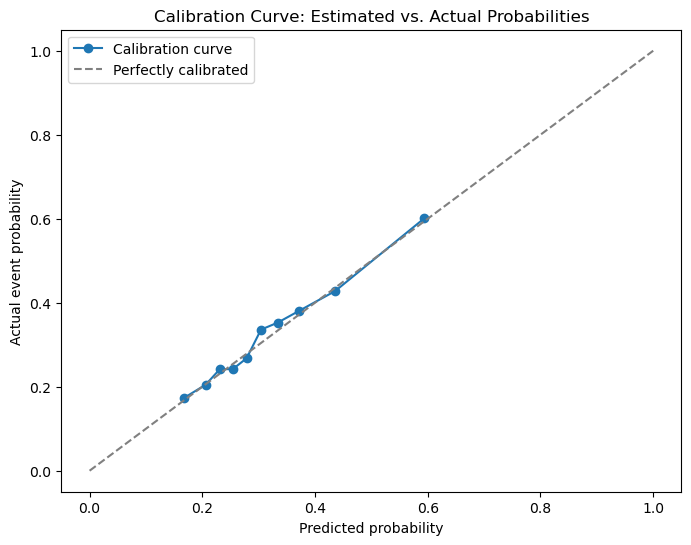

In [56]:
create_calibration_plot(
    data_holdout,
    file_name="ch17-figure-1-logit-m4-calibration",
    prob_var="best_logit_pred_proba",
    actual_var="fast_growth",
    y_lab="Actual event probability",
    n_bins=10,
    breaks=None,
)


### b) Confusion table with different tresholds

Default: the threshold 0.5 is used to convert probabilities to binary classes

Your model is biased toward predicting “No Fast Growth” and misses most actual fast growth cases (recall = 8.8%)! If your goal is to detect fast growth, this model is not reliable yet. You need to improve recall while maintaining a reasonable precision

In [57]:
logit_class_prediction = best_logit.predict(X_holdout)

values, counts = np.unique(logit_class_prediction.tolist(), return_counts=True)
print(values[0], " (not fast growing): ", counts[0])
print(values[1], " (fast growing): ", counts[1])

0.0  (not fast growing):  3476
1.0  (fast growing):  332


Confusion matrix: summarize different type of errors and successfully predicted cases

positive = "yes": explicitly specify the positive case

In [58]:
cm_object1 = confusion_matrix(
    data_holdout["fast_growth"], logit_class_prediction, labels=[0, 1]
)
cm1 = pd.DataFrame(
    cm_object1,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,2450,129
Actual fast growth,1026,203


In [59]:
# we can apply different thresholds

# 0.5 same as before
holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < 0.5, 0, 1)
cm_object1b = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm1b = pd.DataFrame(
    cm_object1b,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm1b

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,2450,129
Actual fast growth,1026,203


A sensible choice: mean of predicted probabilities

In [60]:
mean_predicted_growth_prob = np.mean(data_holdout["best_logit_pred_proba"])
round(mean_predicted_growth_prob, 3)

0.318

In [61]:
holdout_prediction = np.where(
    data_holdout["best_logit_pred_proba"] < mean_predicted_growth_prob, 0, 1
)
cm_object2 = confusion_matrix(
    data_holdout["fast_growth"], holdout_prediction, labels=[0, 1]
)
cm2 = pd.DataFrame(
    cm_object2,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm2

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,1718,861
Actual fast growth,554,675


### c) Visualize ROC (with thresholds in steps) on holdout

What if we want to compare multiple thresholds?

First, discrete ROC (with thresholds in steps) on holdout

In [62]:
thresholds = np.arange(0.05, 0.76, 0.05)
#thresholds = sorted(np.geomspace(0.95, 0.05, num=17)) # set these treshold values to get even points in the plot
cm = dict()
true_positive_rates = []
false_positive_rates = []
holdout_prediction = []
for thr in thresholds:
    holdout_prediction = np.where(data_holdout["best_logit_pred_proba"] < thr, 0, 1)
    cm_thr = confusion_matrix(data_holdout["fast_growth"], holdout_prediction, labels=[0, 1])
    cm[thr] = cm_thr
    tn, fp, fn, tp = cm_thr.ravel()
    true_positive_rates.append(tp / (tp + fn))
    false_positive_rates.append(fp / (fp + tn))

In [63]:
tpr_fpr_for_thresholds = pd.DataFrame(
    {
        "thresholds": thresholds,
        "true_positive_rates": true_positive_rates,
        "false_positive_rates": false_positive_rates,
    }
)

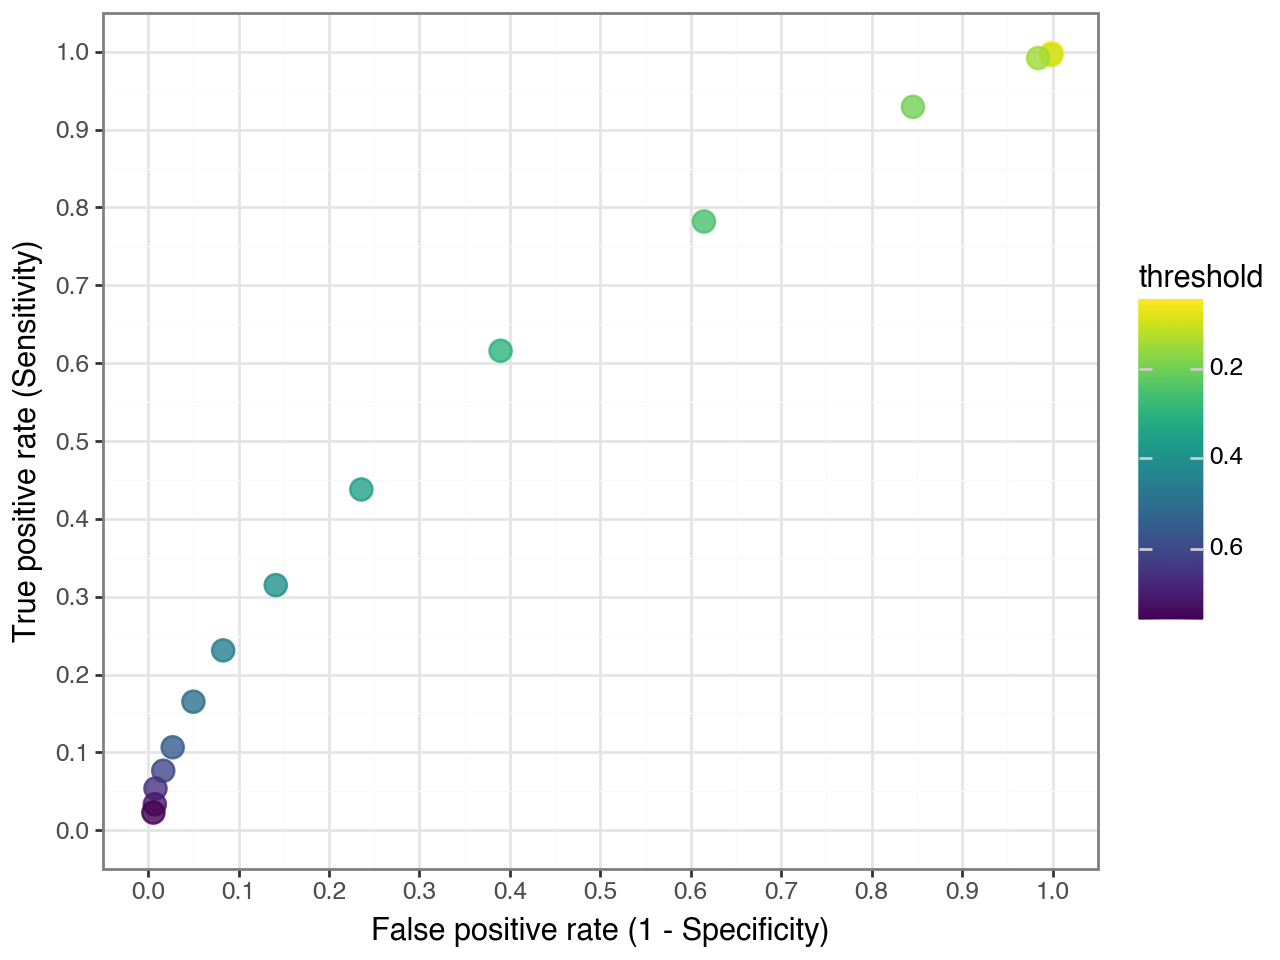

In [64]:
(
    ggplot(
        tpr_fpr_for_thresholds,
        aes(x="false_positive_rates", y="true_positive_rates", color="thresholds"),
    )
    + labs(
        x="False positive rate (1 - Specificity)", y="True positive rate (Sensitivity)"
    )
    + geom_point(size=4, alpha=0.8)
    + scale_color_continuous(trans="reverse", name="threshold")
    + scale_x_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + scale_y_continuous(limits=(0, 1), breaks=np.arange(0, 1.01, 0.1))
    + theme_bw()
    + theme(legend_position="right")
)

Continuous ROC on holdout with best model

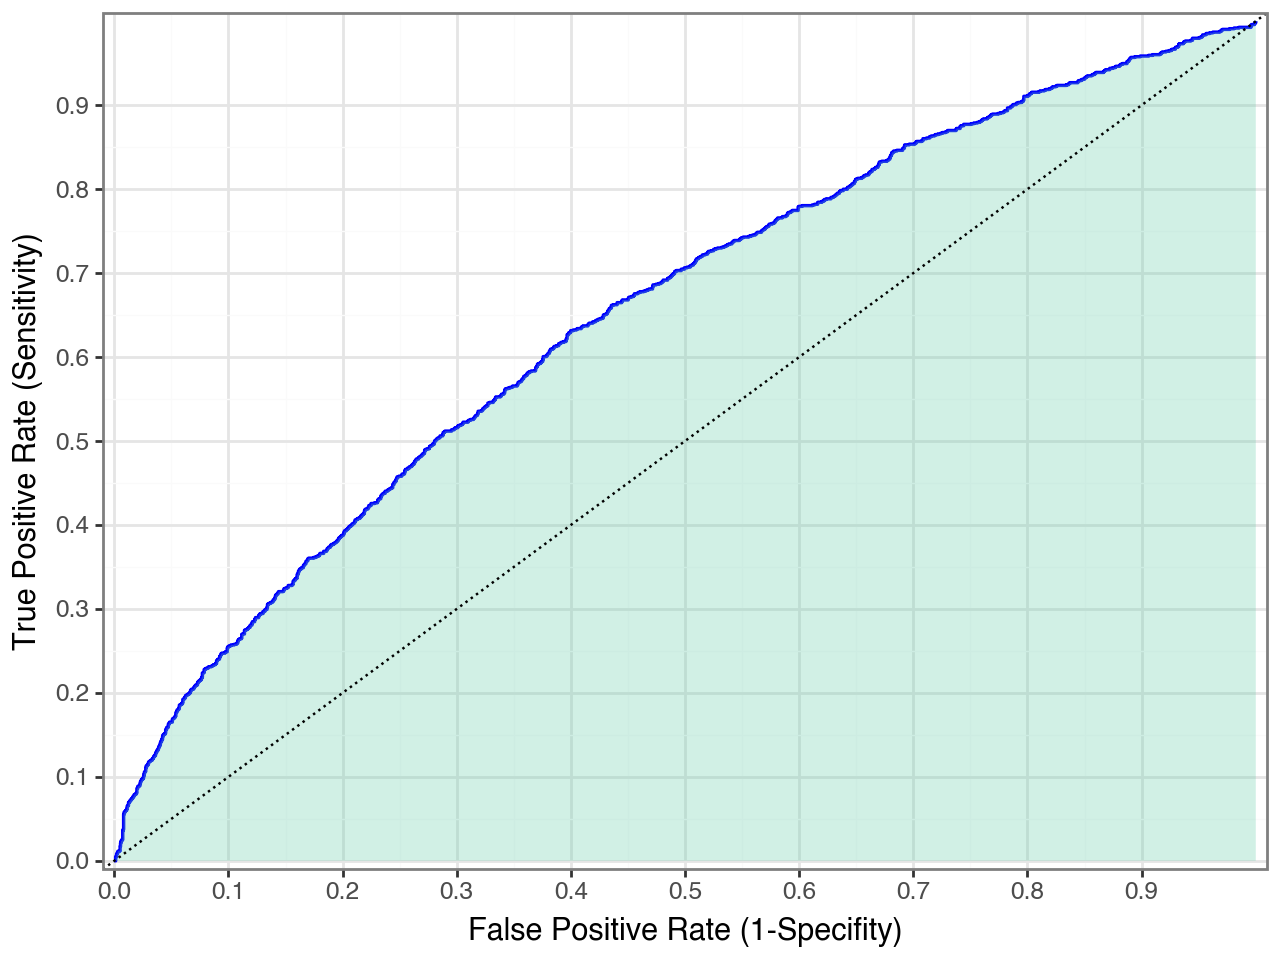

In [65]:
create_roc_plot(data_holdout["fast_growth"], data_holdout["best_logit_pred_proba"])

## 3. We have a loss function

Introduce loss function

Relative cost of of a false negative classification (as compared with a false positive classification)


In [66]:
FP = 1
FN = 10
cost = FN / FP

The prevalence, or the proportion of cases in the population (n.cases/(n.controls+n.cases))


In [67]:
prevelance = y_train.sum() / len(y_train)

Draw ROC Curve and find optimal threshold with loss function 

The optimal cut-off is the threshold that maximizes the distance to the identity (diagonal) line

Iterate through:
 1. models
 2. Folds

In [68]:
best_thresholds_cv = dict()
expected_loss_cv = dict()
fold5_threshold = dict()
fold5_expected_loss = dict()
fold5_all_coords = dict()

for i, model_name in enumerate(logit_models):
    best_thresholds = []
    expected_loss = []

    if model_name != "LASSO":
        _, X = patsy.dmatrices("fast_growth ~" + "+".join(logit_model_vars[i]), data_train)
        X = pd.DataFrame(X)
        c_index = 0
    else:
        X = normalized_logitvars
        c_index = best_lambda_i
    fold = 0
    for train_index, test_index in k.split(X):
        X_fold = X.iloc[test_index, :]
        y_fold = data_train["fast_growth"].iloc[test_index]
        pred_fold = generate_fold_prediction(
            logit_models[model_name], X_fold, fold, c_index
        )
        false_pos_rate, true_pos_rate, thresholds = roc_curve(y_fold, pred_fold)
        optimal_threshold = sorted(
            list(
                zip(
                    np.abs(
                        true_pos_rate
                        + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                    ),
                    thresholds,
                )
            ),
            key=lambda i: i[0],
            reverse=True,
        )[0][1]
        best_thresholds.append(optimal_threshold)
        threshold_prediction = np.where(pred_fold < optimal_threshold, 0, 1)
        tn, fp, fn, tp = confusion_matrix(
            y_fold, threshold_prediction, labels=[0, 1]
        ).ravel()
        curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
        expected_loss.append(curr_exp_loss)
        fold = fold + 1

    best_thresholds_cv[model_name] = np.mean(best_thresholds)
    expected_loss_cv[model_name] = np.mean(expected_loss)

    # for fold #5
    fold5_threshold[model_name] = optimal_threshold
    fold5_expected_loss[model_name] = curr_exp_loss

    all_coords = pd.DataFrame(
        {
            "false_pos": false_pos_rate * sum(y_fold == 0),
            "true_pos": true_pos_rate * sum(y_fold == 1),
            "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
            "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
            "pos": sum(y_fold == 1),
            "neg": sum(y_fold == 0),
            "n": len(y_fold),
            "thresholds": thresholds,
        }
    )

    fold5_all_coords[model_name] = all_coords

In [69]:
summary_with_lossfnc = pd.DataFrame(
    best_thresholds_cv.items(), columns=["Model", "Avg of optimal thresholds"]
)
summary_with_lossfnc["Threshold for Fold5"] = fold5_threshold.values()
summary_with_lossfnc["Avg expected loss"] = expected_loss_cv.values()
summary_with_lossfnc["Expected loss for Fold5"] = fold5_expected_loss.values()


In [70]:
summary_with_lossfnc

,Model,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,M1,0.175087,0.186223,0.685381,0.673892
1,M2,0.106438,0.112699,0.685250,0.674877
2,M3,0.111675,0.126258,0.684068,0.673235
3,M4,0.094285,0.119534,0.684593,0.672250
4,M5,0.028650,0.023665,0.684790,0.674220
5,LASSO,0.047680,0.063861,0.684856,0.674220


Create loss plot based on Fold5 in CV 

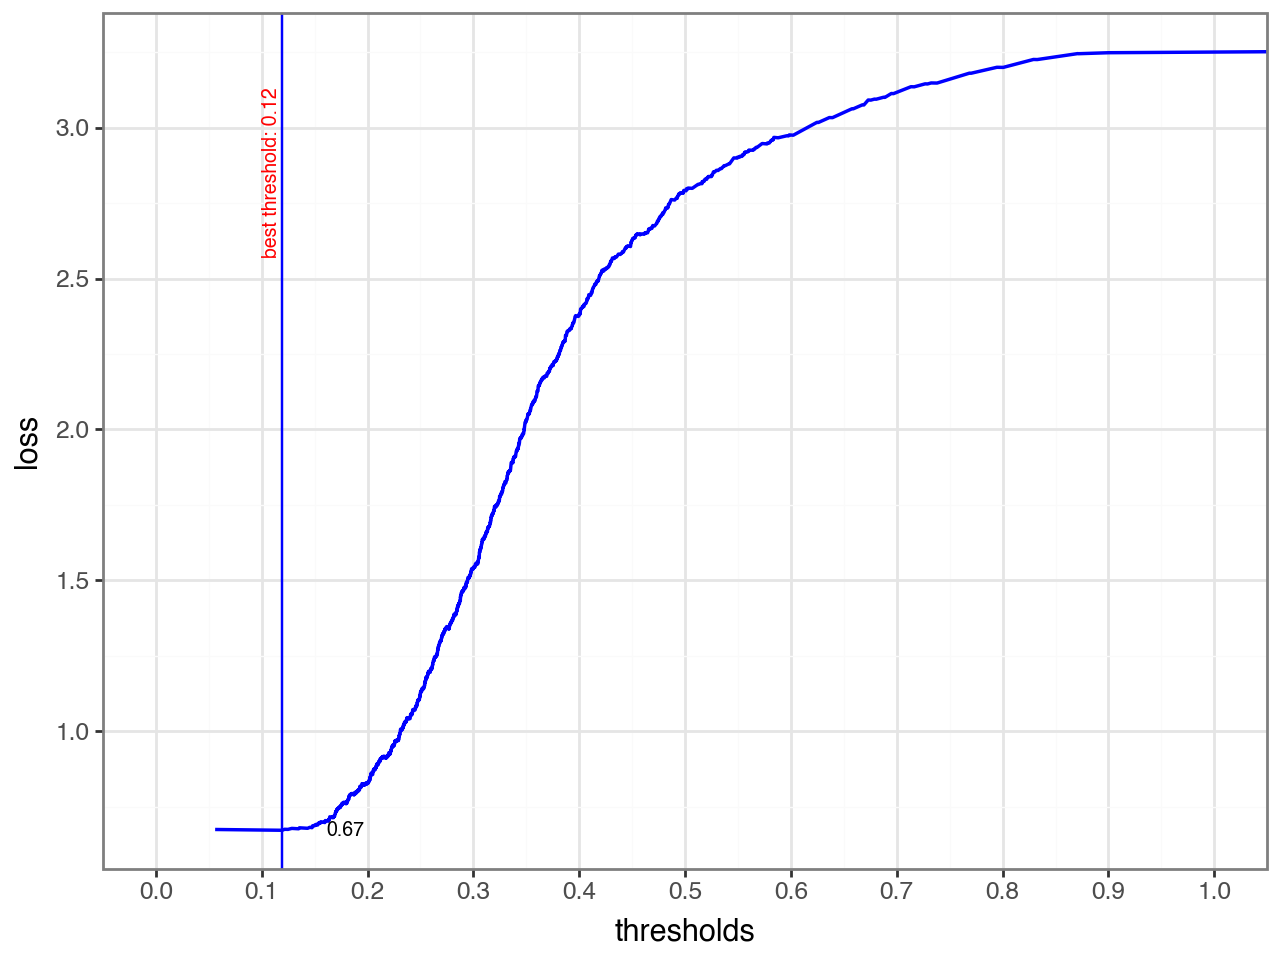

In [71]:
model_to_plot = "M4"  # select model to plot
create_loss_plot(
    fold5_all_coords[model_to_plot],
    fold5_threshold[model_to_plot],
    fold5_expected_loss[model_to_plot],
)

Create roc plot plot based on Fold5 in CV

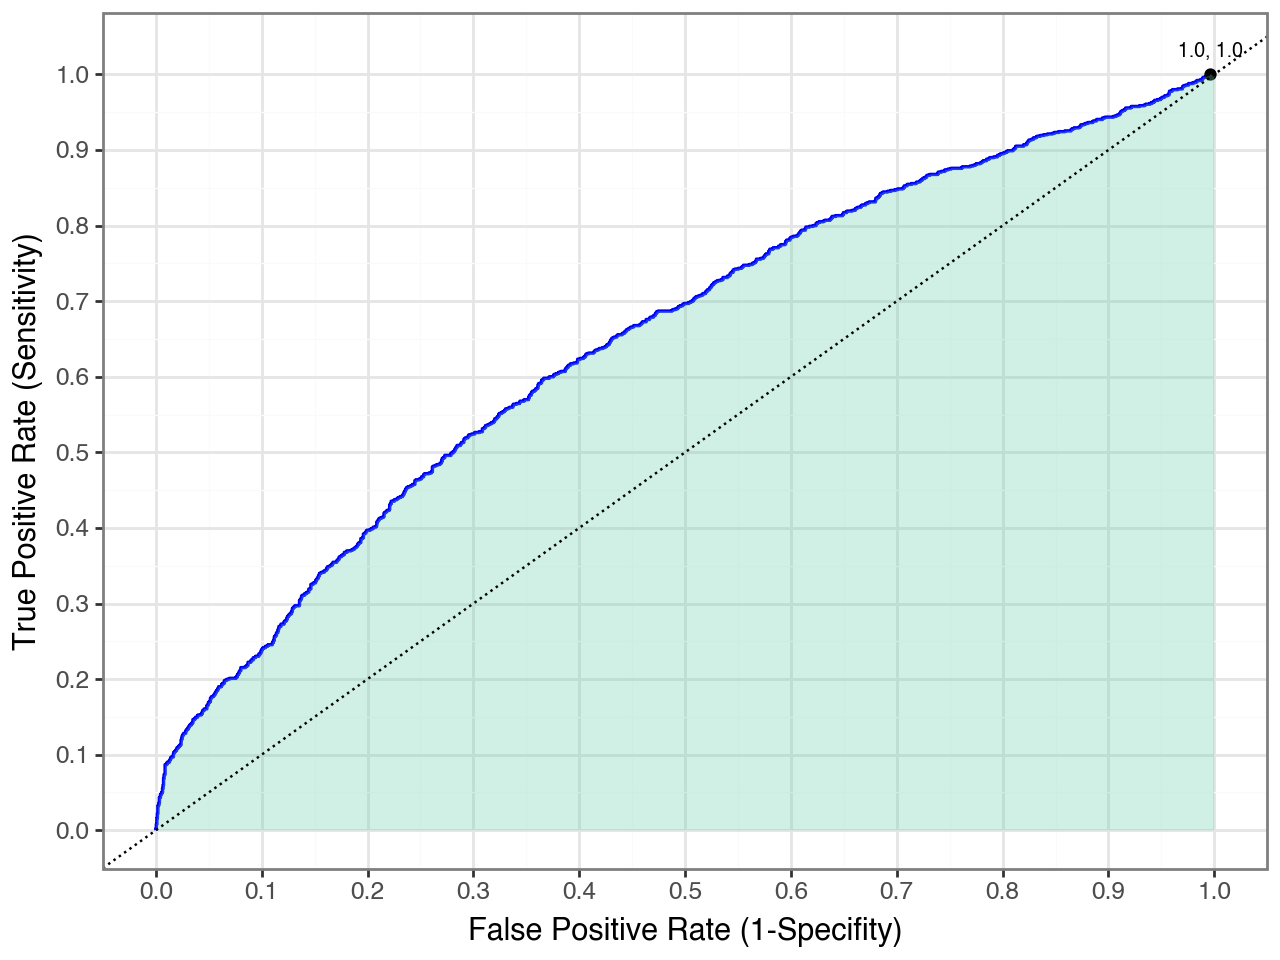

In [72]:
create_roc_plot_with_optimal(
    fold5_all_coords[model_to_plot], fold5_threshold[model_to_plot]
)


Let's see our chosen model, M4's holdout expected loss

In [73]:
best_logit_optimal_treshold = best_thresholds_cv["M4"]

# Get expected loss on holdout
holdout_treshold = np.where(
    data_holdout["best_logit_pred_proba"] < best_logit_optimal_treshold, 0, 1
)
tn, fp, fn, tp = confusion_matrix(
    data_holdout["fast_growth"], holdout_treshold, labels=[0, 1]
).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(data_holdout["fast_growth"])
round(expected_loss_holdout, 3)

0.689

CM on holdout

In [74]:
cm_object3 = confusion_matrix(data_holdout["fast_growth"], holdout_treshold, labels=[0, 1])
cm3 = pd.DataFrame(
    cm_object3,
    index=["Actual no fast growth", "Actual fast growth"],
    columns=["Predicted no fast growth", "Predicted fast growth"],
)
cm3

,Predicted no fast growth,Predicted fast growth
Actual no fast growth,4,2575
Actual fast growth,5,1224


# PREDICTION WITH RANDOM FOREST

In [75]:
y_train, rfvars_train = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_train)
y_holdout, rfvars_holdout = patsy.dmatrices("fast_growth~" + "+".join(rfvars), data_holdout)

## Graph example for decision tree

<Figure size 640x480 with 0 Axes>

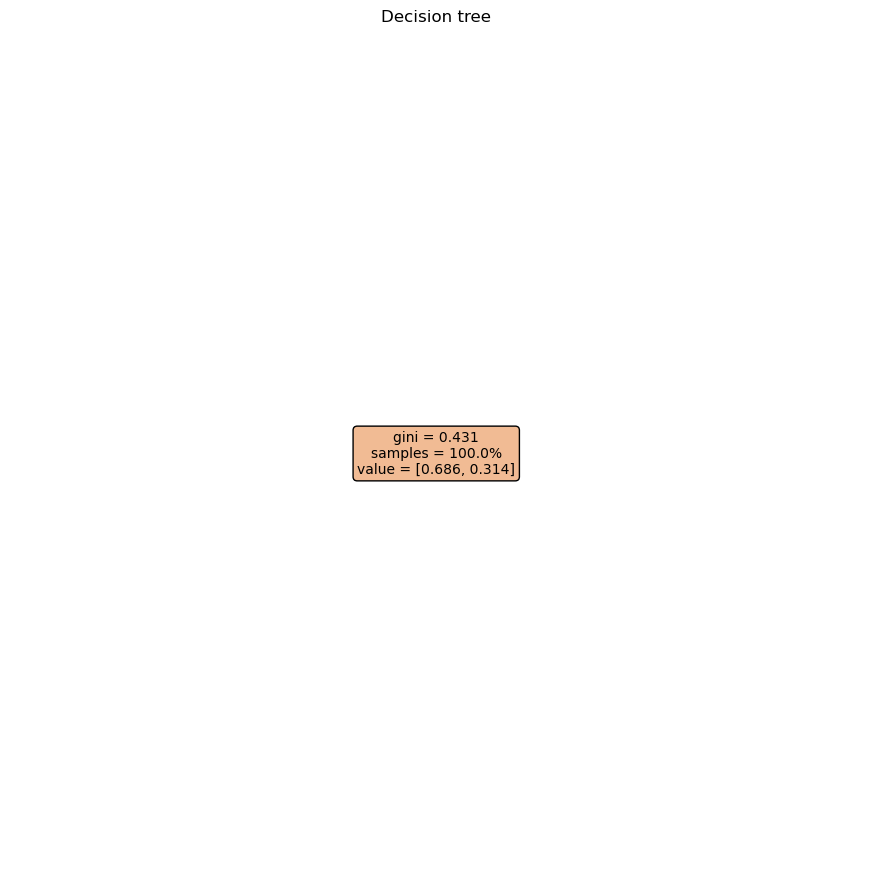

In [76]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

data_for_graph = data_train[[ "profit_loss_year", "foreign_management", #"sales_mil"
                             ]]
rf_for_graph = DecisionTreeClassifier(
    ccp_alpha=0.0028, min_samples_leaf=100, max_depth=3, random_state=41
).fit(data_for_graph, y_train)

plt.figure()
plt.figure(figsize=(11, 11))
plot_tree(
    rf_for_graph,
    feature_names=data_for_graph.columns,
    filled=True,
    rounded=True,
    proportion=True,
    fontsize=10,
)
plt.title("Decision tree")
plt.show()


## Probability forest

Split by gini, ratio of 1's in each tree, average over trees

In [77]:
grid = {
    "max_features": [5, 6, 7],
    "criterion": ["gini"],
    "min_samples_split": [11, 16],
} 

5 fold cross validation

In [78]:
prob_forest = RandomForestClassifier(random_state=42, n_estimators=500, oob_score=True)
prob_forest_grid = GridSearchCV(
    prob_forest,
    grid,
    cv=k,
    refit="roc_auc",
    scoring=["roc_auc", "neg_brier_score"],
)

In [ ]:
prob_forest_fit = prob_forest_grid.fit(rfvars_train, y_train)

Create CV summary table

In [ ]:
prob_forest_cv_results = pd.DataFrame(
    {
        "max_features": prob_forest_fit.cv_results_["param_max_features"],
        "min_samples_split": prob_forest_fit.cv_results_["param_min_samples_split"],
        "cv_auc": prob_forest_fit.cv_results_["mean_test_roc_auc"],
        "cv_rmse": np.sqrt(
            prob_forest_fit.cv_results_["mean_test_neg_brier_score"] * -1
        ),
    }
)

prob_forest_cv_results

,max_features,min_samples_split,cv_auc,cv_rmse
0,5,11,0.883121,0.287441
1,5,16,0.883446,0.287353
2,6,11,0.883288,0.287337
3,6,16,0.883659,0.287157
4,7,11,0.883274,0.287267
5,7,16,0.883829,0.287113


Obtain optimal parameter values

In [ ]:
best_mtry = prob_forest_fit.best_params_["max_features"]
best_min_node_size = prob_forest_fit.best_params_["min_samples_split"]
prob_forest_fit.best_params_


{'criterion': 'gini', 'max_features': 7, 'min_samples_split': 16}

Get average (ie over the folds) RMSE and AUC

In [ ]:
prob_forest_best_results = prob_forest_cv_results[
    (prob_forest_cv_results.max_features == best_mtry)
    & (prob_forest_cv_results.min_samples_split == best_min_node_size)
]
prob_forest_best_results_index = prob_forest_best_results.index.values[0]

In [ ]:
summary.loc["RF", "Number of Coefficients"] = "n.a."
summary.loc["RF", "CV RMSE"] = prob_forest_best_results["cv_rmse"].values[0]
summary.loc["RF", "CV AUC"] = prob_forest_best_results["cv_auc"].values[0]
summary

,Number of Coefficients,CV RMSE,CV AUC
M1,9.0,0.330690,0.592583
M2,16.0,0.330498,0.600141
M3,31.0,0.297007,0.871998
M4,75.0,0.299545,0.869751
M5,139.0,0.295515,0.873172
LASSO,98.0,0.290348,0.878262
RF,n.a.,0.287113,0.883829


Extract fold level RMSE and AUC

In [ ]:
CV_RMSE_folds["RF"] = np.sqrt(
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_neg_brier_score")
    .loc[lambda x: x["rank_test_neg_brier_score"] == 1]
    .filter(like="split")
    .values[0]
    * -1
)
CV_AUC_folds["RF"] = (
    pd.DataFrame(prob_forest_fit.cv_results_)
    .filter(like="_test_roc_auc")
    .loc[lambda x: x["rank_test_roc_auc"] == 1]
    .filter(like="split")
    .values[0]
)

Take a look at foldwise RMSE and AUC

In [ ]:
pd.DataFrame(CV_RMSE_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.338682,0.338608,0.302766,0.307427,0.299002,0.293886,0.290783
1,0.327945,0.327660,0.295242,0.298070,0.293948,0.290570,0.287048
2,0.326816,0.326647,0.291840,0.293397,0.292977,0.287434,0.284499
3,0.334376,0.334353,0.300860,0.306227,0.300319,0.295070,0.291331
4,0.325631,0.325221,0.294327,0.292604,0.291326,0.284781,0.281788


In [ ]:
pd.DataFrame(CV_AUC_folds)

,M1,M2,M3,M4,M5,LASSO,RF
0,0.597311,0.600985,0.878251,0.865636,0.878178,0.883310,0.887644
1,0.590598,0.595940,0.871791,0.873316,0.871114,0.872677,0.880036
2,0.588190,0.594032,0.869112,0.869898,0.871594,0.878256,0.883313
3,0.598202,0.607358,0.868975,0.864181,0.868990,0.874124,0.878399
4,0.588617,0.602388,0.871861,0.875724,0.875985,0.882941,0.889753


Now use loss function and search for best thresholds and expected loss over folds 

In [ ]:
best_thresholds = list()
expected_loss = list()
rfvars_train = pd.DataFrame(rfvars_train)

fold = 0
for train_index, test_index in k.split(rfvars_train):
    X_fold = rfvars_train.iloc[test_index, :]
    y_fold = data_train["fast_growth"].iloc[test_index]

    X_fold_train = rfvars_train.iloc[train_index, :]
    y_fold_train = data_train["fast_growth"].iloc[train_index]

    prob_forest_best = RandomForestClassifier(
        random_state=42,
        n_estimators=500,
        oob_score=True,
        criterion="gini",
        max_features=best_mtry,
        min_samples_split=best_min_node_size,
    )
    prob_forest_best_fold = prob_forest_best.fit(X_fold_train, y_fold_train)
    pred_fold = prob_forest_best_fold.predict_proba(X_fold)[:, 1]

    false_pos_rate, true_pos_rate, threshold = roc_curve(y_fold, pred_fold)
    best_threshold = sorted(
        list(
            zip(
                np.abs(
                    true_pos_rate
                    + (1 - prevelance) / (cost * prevelance) * (1 - false_pos_rate)
                ),
                threshold,
            )
        ),
        key=lambda x: x[0],
        reverse=True,
    )[0][1]
    best_thresholds.append(best_threshold)
    threshold_prediction = np.where(pred_fold < best_threshold, 0, 1)
    tn, fp, fn, tp = confusion_matrix(
        y_fold, threshold_prediction, labels=[0, 1]
    ).ravel()
    curr_exp_loss = (fp * FP + fn * FN) / len(y_fold)
    expected_loss.append(curr_exp_loss)

fold5_threshold_rf = best_threshold
fold5_expected_loss_rf = curr_exp_loss

all_coords_rf = pd.DataFrame(
    {
        "false_pos": false_pos_rate * sum(y_fold == 0),
        "true_pos": true_pos_rate * sum(y_fold == 1),
        "false_neg": sum(y_fold == 1) - true_pos_rate * sum(y_fold == 1),
        "true_neg": sum(y_fold == 0) - false_pos_rate * sum(y_fold == 0),
        "pos": sum(y_fold == 1),
        "neg": sum(y_fold == 0),
        "n": len(y_fold),
        "thresholds": threshold,
    }
)


In [ ]:
expected_loss_cv["RF"] = np.mean(expected_loss)
best_thresholds_cv["RF"] = np.mean(best_thresholds)


In [ ]:
rf_summary = pd.DataFrame(
    {
        "CV RMSE": [round(prob_forest_best_results["cv_rmse"].values[0], 3)],
        "CV AUC": [round(prob_forest_best_results["cv_auc"].values[0], 3)],
        "Avg of optimal thresholds": [round(best_thresholds_cv["RF"], 3)],
        "Threshold for Fold5": [round(best_threshold, 3)],
        "Avg expected loss": [round(expected_loss_cv["RF"], 3)],
        "Expected loss for Fold5": [round(curr_exp_loss, 3)],
    }
)

rf_summary

,CV RMSE,CV AUC,Avg of optimal thresholds,Threshold for Fold5,Avg expected loss,Expected loss for Fold5
0,0.287,0.884,0.119,0.154,0.298,0.292


Create plots based on Fold5 in CV 

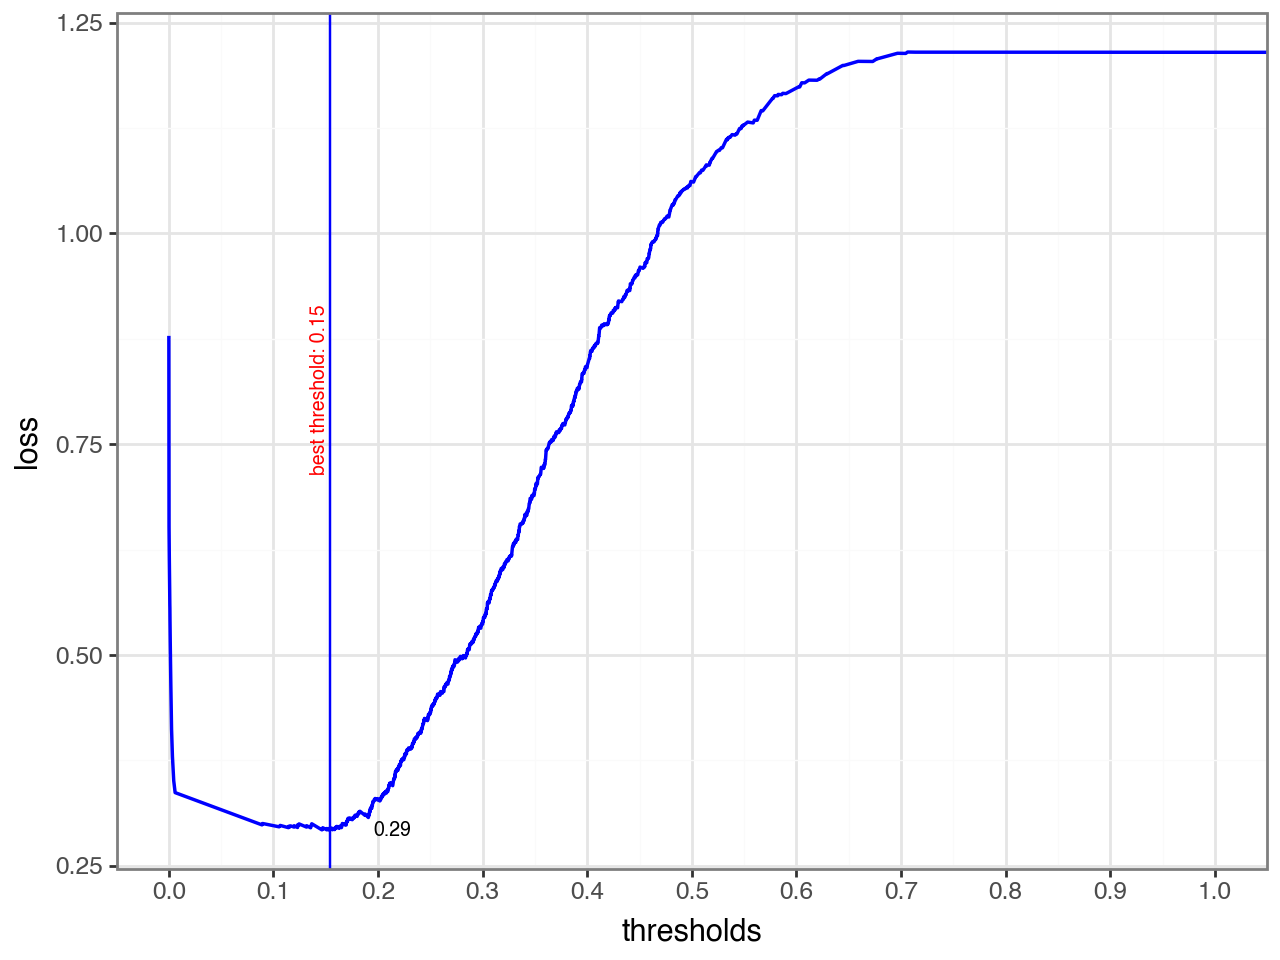

In [ ]:
create_loss_plot(all_coords_rf, fold5_threshold_rf, fold5_expected_loss_rf)

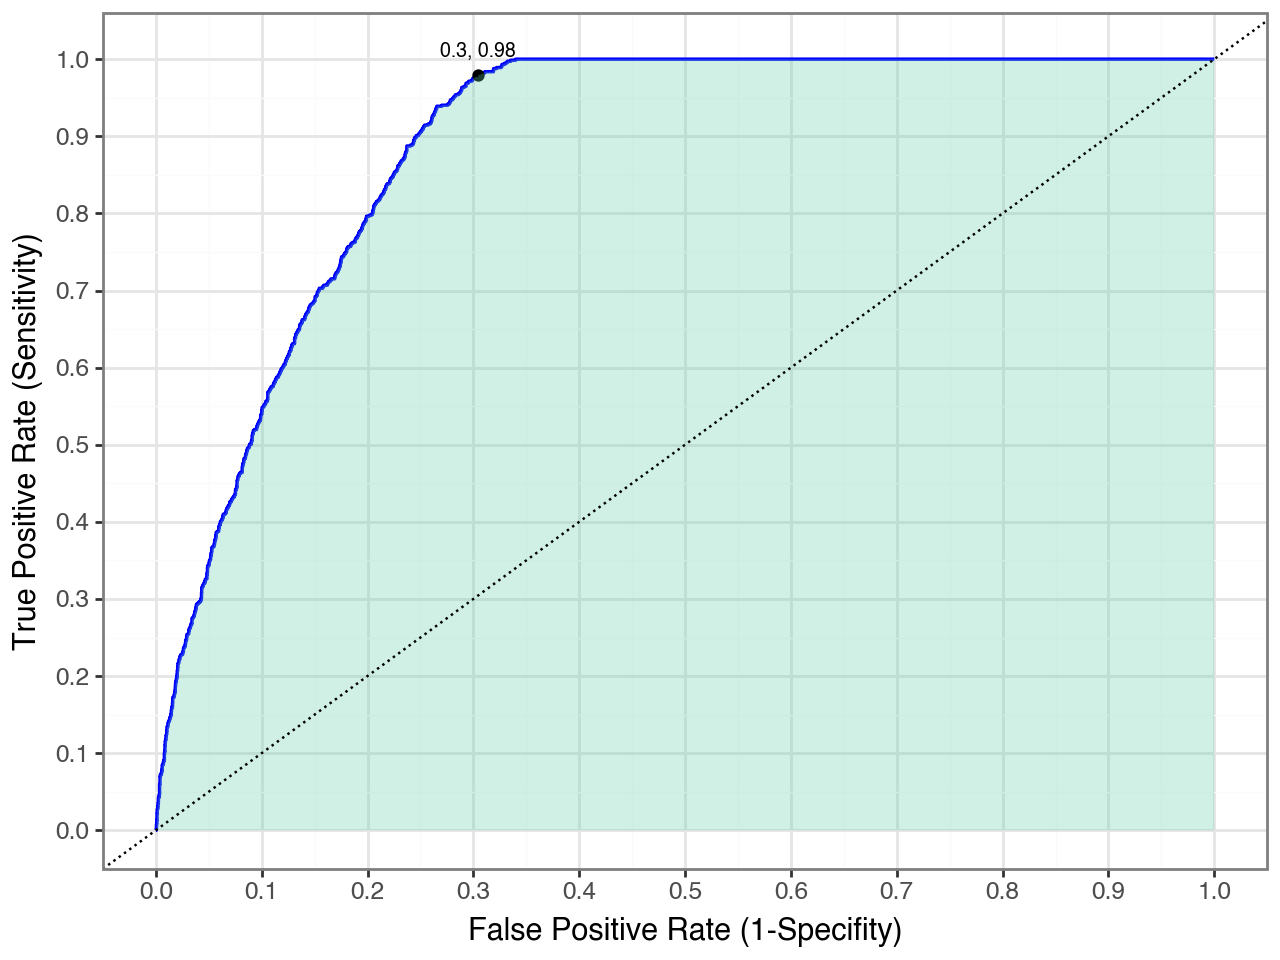

In [ ]:
create_roc_plot_with_optimal(all_coords_rf, fold5_threshold_rf)

Take model to holdout and estimate RMSE, AUC and expected loss 

In [ ]:
prob_forest_fit_best = prob_forest_fit.best_estimator_
rf_predicted_probabilities_holdout = prob_forest_fit_best.predict_proba(rfvars_holdout)[
    :, 1
]
rmse_rf = np.sqrt(mean_squared_error(y_holdout, rf_predicted_probabilities_holdout))
round(rmse_rf, 3)


0.288

ROC AUC  on holdout

In [ ]:
auc_rf = roc_auc_score(y_holdout, rf_predicted_probabilities_holdout)
round(auc_rf, 3)


0.886

 Get expected loss on holdout

In [ ]:
holdout_treshold = np.where(
    rf_predicted_probabilities_holdout < best_thresholds_cv["RF"], 0, 1
)
tn, fp, fn, tp = confusion_matrix(y_holdout, holdout_treshold, labels=[0, 1]).ravel()
expected_loss_holdout = (fp * FP + fn * FN) / len(y_holdout)
round(expected_loss_holdout, 3)


0.292

## Final results

In [ ]:
summary["CV treshold"] = best_thresholds_cv
summary["CV expected Loss"] = expected_loss_cv

In [ ]:
summary

,Number of Coefficients,CV RMSE,CV AUC,CV treshold,CV expected Loss
M1,9.0,0.330690,0.592583,0.097844,0.820340
M2,16.0,0.330498,0.600141,0.101677,0.811769
M3,31.0,0.297007,0.871998,0.131759,0.298401
M4,75.0,0.299545,0.869751,0.102978,0.304632
M5,139.0,0.295515,0.873172,0.089899,0.302884
LASSO,98.0,0.290348,0.878262,0.053079,0.299885
RF,n.a.,0.287113,0.883829,0.118564,0.297643
